<a href="https://colab.research.google.com/github/dnguyen1196/Horseshoe-VAE/blob/master/Horseshoe_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download KEGG file from drive



In [3]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1RwjZaMjdDmqceedNCu3VvGI3bqQQn9g2'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content KEGG file')

import networkx as nx

G = nx.read_gpickle(“kegg.ungraph.pkl”)

for n in G.nodes:
    print(“Fingerprints for node %s: %r” % (n, G.nodes[n][“fingerprint”]))
    break

Downloaded content KEGG file


# Install torch

NOTE:
Compared to the reference VAE implementation, the main difference is in the calc_vi_loss function
where the likelihood term has been augmented with the loss term to reconstruct the adjacency matrix


In [0]:
# Install the necssary packages
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

# Standard VAE class

In [0]:
from __future__ import print_function


import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable


class NeuralNetwork(nn.Module):
    def __init__(
            self,
            n_dims_code=16,
            n_dims_data=32,
            hidden_layer_sizes=[32],
            encoder=True,):
        
        """
        q_sigma = 0.2
        """
        super(NeuralNetwork, self).__init__()

        self.n_dims_data = n_dims_data
        self.n_dims_code = n_dims_code
        layer_sizes = (
            [n_dims_data] + hidden_layer_sizes + [n_dims_code]
        )
        self.n_layers = len(layer_sizes) - 1

        if not encoder:
            layer_sizes = [a for a in reversed(layer_sizes)]

        self.activations = list()
        self.params = nn.ModuleList()
        for (n_in, n_out) in zip(layer_sizes[:-1], layer_sizes[1:]):
            self.params.append(nn.Linear(n_in, n_out))
            self.activations.append(F.relu)
        self.activations[-1] = lambda a: a

            
    def forward(self, x):
        # Note that if x contains multiple instance
        # if x.shape = (num_sample, in_dim)
        # then the output shape will be (num_sample, out_dim)
        cur_arr = x
        for ll in range(self.n_layers):
            linear_func = self.params[ll]
            a_func = self.activations[ll]
            cur_arr = a_func(linear_func(cur_arr))
        mu_NC = cur_arr
        return mu_NC

      
class VariationalAutoencoder(nn.Module):
    def __init__(
            self,
            q_sigma=0.2,
            n_dims_code=16,
            n_dims_data=64,
            hidden_layer_sizes=[32],
            hsp=False
    ):

        super(VariationalAutoencoder, self).__init__()
        self.n_dims_data = n_dims_data
        self.n_dims_code = n_dims_code
        self.q_sigma = torch.Tensor([float(q_sigma)])
        encoder_layer_sizes = (
            [n_dims_data] + hidden_layer_sizes + [n_dims_code]
        )
        self.n_layers = len(encoder_layer_sizes) - 1
        
        if not hsp:
            # Encoder network
            self.encoder = NeuralNetwork(
                n_dims_code=n_dims_code,
                n_dims_data=n_dims_data,
                hidden_layer_sizes=hidden_layer_sizes,
                encoder=True,
            )
            # Decoder network
            self.decoder = NeuralNetwork(
                n_dims_code=n_dims_code,
                n_dims_data=n_dims_data,
                hidden_layer_sizes=hidden_layer_sizes,
                encoder=False,
            )
        else:
            # TODO: FactorizedInv-Gamma
            # Use Ghosh's implementation of the factorizedInv-Gamma inference
            # engine or reimplement his code with pytorch
            
            pass
        

    def forward(self, x_ND):
        """
        Run entire probabilistic autoencoder on input (encode then decode)

        Returns
        -------
        xproba_ND : 1D array, size of x_ND
        """
        mu_NC = self.encode(x_ND)
        z_NC = self.draw_sample_from_q(mu_NC)
        return self.decode(z_NC), mu_NC

    
    def draw_sample_from_q(self, mu_NC):
        ''' Draw sample from the probabilistic encoder q(z|mu(x), \sigma)

        We assume that "q" is Normal with:
        * mean mu (argument of this function)
        * stddev q_sigma (attribute of this class, use self.q_sigma)

        Args
        ----
        mu_NC : tensor-like, N x C
            Mean of the encoding for each of the N images in minibatch.

        Returns
        -------
        z_NC : tensor-like, N x C
            Exactly one sample vector for each of the N images in minibatch.
        '''
        # Number of samples
        N = mu_NC.shape[0]
        
        # The dimension of the code
        C = self.n_dims_code

        if self.training:
            # Draw standard normal samples "epsilon"
            # Use the reparameterization trick
            eps_NC = torch.randn(N, C)
            z_NC = mu_NC + eps_NC * self.q_sigma
            return z_NC
        else:
            # For evaluations, we always just use the mean
            return mu_NC

    def encode(self, x_ND):
        """
        Args
        ----
        x_ND: the observation vector
        """
        return self.encoder.forward(x_ND)

    def decode(self, z_NC):
        """
        Args
        ----
        z_NC: the code vector
        """
        return self.decoder.forward(z_NC)

    def binary_predict_error_rate(self, f_predict, f_true):
        """
        
        """
        length = f_predict.size()[0]
        f_predict_binary = (f_predict > 0.5).type(torch.FloatTensor)
        error = torch.sum((f_predict_binary - f_true).abs_()) / length
        return error

    def calc_vi_loss(self, xs_ND, ys_ND, vals, n_mc_samples=1):
        """
        Args

        xs_ND: the input feature vectors
        ys_ND: the other feature vectors in mini-batch
        vals: the entry associated with (x,y)
        n_mc_samples: 

        ----
        Returns:
        loss

        """
        neg_expected_ll = 0.0
        # Given a (potentially) a tensor of observation vectors, 
        # Encode it into latent space
        mx_NC = self.encode(xs_ND)
        my_NC = self.encode(ys_ND)
        
        # Compute the KL divergence
        # KL(N(mx_NC, q_sigma) || N(0, I))
        kl_xz_NC = -0.5 * torch.sum(1 + torch.log(self.q_sigma ** 2) - mx_NC ** 2 - self.q_sigma ** 2)
        kl_yz_NC = -0.5 * torch.sum(1 + torch.log(self.q_sigma ** 2) - my_NC ** 2 - self.q_sigma ** 2)
        kl       = kl_xz_NC + kl_yz_NC # Total KL term
        
        # Generate samples from N(mx_NC, q_sigma) to compute the following
        # E_q[log p(x_ND|mx_NC)]
        for ss in range(n_mc_samples):
            sample_z_NC      = self.draw_sample_from_q(mx_NC)
            sample_xproba_ND = self.decode(sample_z_NC)

            # Use MSE to measure reconstruction loss
            # Since MSE is equivalent to log gaussian loss
            sample_mse_loss  = F.mse_loss(sample_xproba_ND, xs_ND)

            # KL divergence from q(mu, sigma) to prior (std normal)
            neg_expected_ll += 1/n_mc_samples * sample_mse_loss
        
        
        # Compute the loss from adjacency matrix reconstruction
        # Get number of entries
        num_samples = len(vals)
        f_predict   = torch.zeros(num_samples)

        # Compute
        # E_q[log p(A_ij|x_i, x_j)] = E_q[Bern(A_ij|sigmoid(x_i dot x_j))]
        
        for ss in range(n_mc_samples):
            # These two should have the same shape
            # which is (N*C)
            sample_z_NC = self.draw_sample_from_q(mx_NC)
            sample_y_NC = self.draw_sample_from_q(my_NC)

            # inner_prod.shape = (N,)
            inner_prod  = torch.sum(sample_z_NC * sample_y_NC, dim=1)
            f_predict  += 1/n_mc_samples * torch.sigmoid(inner_prod)

        # Use binary cross entry loss, NOTE that this is for
        # adjacency matrix whose entry values are 0 and 1
        # This will need to change for other types of adjacency matrix value
        # Use the binary prediction loss with logits
        matrix_reconstruction_loss = \
            F.binary_cross_entropy(f_predict, Variable(torch.FloatTensor(vals)), reduction='sum')
        
        neg_expected_ll += matrix_reconstruction_loss
        
        return neg_expected_ll, kl, matrix_reconstruction_loss, sample_xproba_ND
      
      

class VariationalAutoencoderHSP(VariationalAutoencoder):
    def __init__(self,inference_engine,**kwargs,):

        super(VariationalAutoencoderHSP, self).__init__(**kwargs)
        assert inference_engine
        self.inference_engine = inference_engine


# VAE with horseshoe priors

In [0]:
""" Uses a non-centered parameterization of the model.
    Fully factorized Gaussian + IGamma Variational distribution
	q = N(w_ijl | m_ijl, sigma^2_ijl) N(ln \tau_kl | params) IGamma(\lambda_kl| params)
	IGamma(\tau_l | params) IGamma(\lambda_l| params)
"""

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.misc import logsumexp
from autograd.scipy.special import gammaln, psi
from src.utility_functions import diag_gaussian_entropy, inv_gamma_entropy, log_normal_entropy


class FactorizedHierarchicalInvGamma:
    def __init__(self, n_weights, lambda_a, lambda_b, lambda_b_global, tau_a, shapes, train_stats, classification=False,
                 n_data=None):
        self.name = "Factorized Hierarchical Inverse Gamma Variational Approximation"
        self.classification = classification
        self.n_weights = n_weights
        self.shapes = shapes
        self.num_hidden_layers = len(shapes) - 1
        self.lambda_a_prior = lambda_a
        self.lambda_b_prior = lambda_b
        self.lambda_a_prior_global = 0.5
        self.lambda_b_prior_global = lambda_b_global
        self.lambda_a_prior_oplayer = 0.5
        self.lambda_b_prior_oplayer = 1.
        self.tau_a_prior = tau_a
        self.tau_a_prior_global = 0.5
        self.tau_a_prior_oplayer = 0.5
        self.l2pi = np.log(2 * np.pi)
        self.n_data = n_data
        self.noise_entropy = None
        if not self.classification:
            # gamma(6, 6) prior on precision
            self.noise_a = 6.
            self.noise_b = 6.
            self.train_stats = train_stats

    ######### PACK UNPACK PARAMS #################################################
    def initialize_variational_params(self, param_scale=1):
        # Initialize weights
        wlist = list()
        for m, n in self.shapes:
            wlist.append(npr.randn(m * n) * np.sqrt(2 / m))
            wlist.append(np.zeros(n))  # bias
        w = np.concatenate(wlist)
        log_sigma = param_scale * npr.randn(w.shape[0]) - 10.
        # initialize scale parameters
        self.tot_outputs = 0
        for _, num_hl_outputs in self.shapes:
            self.tot_outputs += num_hl_outputs
        # No hs priors on the outputs
        self.tot_outputs = self.tot_outputs - self.shapes[-1][1]
        if not self.classification:
            tau_mu, tau_log_sigma, tau_global_mu, tau_global_log_sigma, tau_oplayer_mu, tau_oplayer_log_sigma, log_a, \
                                log_b = self.initialize_scale_from_prior()
            init_params = np.concatenate([w.ravel(), log_sigma.ravel(),
                                          tau_mu.ravel(), tau_log_sigma.ravel(), tau_global_mu.ravel(),
                                          tau_global_log_sigma.ravel(), tau_oplayer_mu, tau_oplayer_log_sigma, log_a,
                                          log_b])
        else:
            tau_mu, tau_log_sigma, tau_global_mu, tau_global_log_sigma, tau_oplayer_mu, tau_oplayer_log_sigma = \
                self.initialize_scale_from_prior()
            init_params = np.concatenate([w.ravel(), log_sigma.ravel(),
                                          tau_mu.ravel(), tau_log_sigma.ravel(), tau_global_mu.ravel(),
                                          tau_global_log_sigma.ravel(), tau_oplayer_mu, tau_oplayer_log_sigma])

        return init_params

    def initialize_scale_from_prior(self):
        # scale parameters (hidden + observed),
        self.lambda_a_hat = (self.tau_a_prior + self.lambda_a_prior) * np.ones([self.tot_outputs, 1]).ravel()
        self.lambda_b_hat = (1.0 / self.lambda_b_prior ** 2) * np.ones([self.tot_outputs, 1]).ravel()
        self.lambda_a_hat_global = (self.tau_a_prior_global + self.lambda_a_prior_global)  \
            * np.ones([self.num_hidden_layers, 1]).ravel()
        self.lambda_b_hat_global = (1.0 / self.lambda_b_prior_global ** 2) * np.ones(
            [self.num_hidden_layers, 1]).ravel()
        # set oplayer lambda param
        self.lambda_a_hat_oplayer = np.array(self.tau_a_prior_oplayer + self.lambda_a_prior_oplayer).reshape(-1)
        self.lambda_b_hat_oplayer = (1.0 / self.lambda_b_prior_oplayer ** 2) * np.ones([1]).ravel()
        # sample from half cauchy and log to initialize the mean of the log normal
        sample = np.abs(self.lambda_b_prior * (npr.randn(self.tot_outputs) / npr.randn(self.tot_outputs)))
        tau_mu = np.log(sample)
        tau_log_sigma = npr.randn(self.tot_outputs) - 10.
        # one tau_global for each hidden layer
        sample = np.abs(
            self.lambda_b_prior_global * (npr.randn(self.num_hidden_layers) / npr.randn(self.num_hidden_layers)))
        tau_global_mu = np.log(sample)
        tau_global_log_sigma = npr.randn(self.num_hidden_layers) - 10.
        # one tau for all op layer weights
        sample = np.abs(self.lambda_b_hat_oplayer * (npr.randn() / npr.randn()))
        tau_oplayer_mu = np.log(sample)
        tau_oplayer_log_sigma = npr.randn(1) - 10.
        if not self.classification:
            log_a = np.array(np.log(self.noise_a)).reshape(-1)
            log_b = np.array(np.log(self.noise_b)).reshape(-1)
            return tau_mu, tau_log_sigma, tau_global_mu, tau_global_log_sigma, tau_oplayer_mu, tau_oplayer_log_sigma, \
                   log_a, log_b
        else:
            return tau_mu, tau_log_sigma, tau_global_mu, tau_global_log_sigma, tau_oplayer_mu, tau_oplayer_log_sigma

    def unpack_params(self, params):
        # unpack params
        w_vect = params[:self.n_weights]
        num_std = 2 * self.n_weights
        sigma = np.log(1 + np.exp(params[self.n_weights:num_std]))
        tau_mu = params[num_std:num_std + self.tot_outputs]
        tau_sigma = np.log(
            1 + np.exp(params[num_std + self.tot_outputs:num_std + 2 * self.tot_outputs]))
        tau_mu_global = params[num_std + 2 * self.tot_outputs: num_std + 2 * self.tot_outputs + self.num_hidden_layers]
        tau_sigma_global = np.log(1 + np.exp(params[num_std + 2 * self.tot_outputs + self.num_hidden_layers:num_std +
                                                                    2 * self.tot_outputs + 2 * self.num_hidden_layers]))
        tau_mu_oplayer = params[num_std + 2 * self.tot_outputs + 2 * self.num_hidden_layers: num_std +
                                                                2 * self.tot_outputs + 2 * self.num_hidden_layers + 1]
        tau_sigma_oplayer = np.log(
            1 + np.exp(params[num_std + 2 * self.tot_outputs + 2 * self.num_hidden_layers + 1:]))
        if not self.classification:
            a = tau_sigma_oplayer[1]
            b = tau_sigma_oplayer[2]
            tau_sigma_oplayer = tau_sigma_oplayer[0]
            egamma = a / b
            elog_gamma = psi(a) - np.log(b)
            self.noise_entropy = inv_gamma_entropy(a, b)
            #  we will just use a point estimate of noise_var b/a+1 (noise_var ~ IGamma) for computing predictive ll
            self.noisevar = (b / (a + 1)) * self.train_stats['sigma'] ** 2
            return w_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, \
                   tau_sigma_oplayer, elog_gamma, egamma
        else:
            return w_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer

    def unpack_layer_weight_variances(self, sigma_vect):
        for m, n in self.shapes:
            yield sigma_vect[:m * n].reshape((m, n)), sigma_vect[m * n:m * n + n]
            sigma_vect = sigma_vect[(m + 1) * n:]

    def unpack_layer_weight_priors(self, tau_vect):
        for m, n in self.shapes:
            yield tau_vect[:n]
            tau_vect = tau_vect[n:]

    def unpack_layer_weights(self, w_vect):
        for m, n in self.shapes:
            yield w_vect[:m * n].reshape((m, n)), w_vect[m * n:m * n + n]
            w_vect = w_vect[(m + 1) * n:]

    ######### Fixed Point Updates ################################## #####
    def fixed_point_updates(self, params):
        if self.classification:
            w_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer = \
                self.unpack_params(params)
        else:
            w_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer, _, _ \
                = self.unpack_params(params)
        # update lambda moments
        self.lambda_b_hat = np.exp(-tau_mu + 0.5 * tau_sigma ** 2) + (1. / self.lambda_b_prior ** 2)
        self.lambda_b_hat_global = np.exp(-tau_mu_global + 0.5 * tau_sigma_global ** 2) + (
            1. / self.lambda_b_prior_global ** 2)
        self.lambda_b_hat_oplayer = np.exp(-tau_mu_oplayer + 0.5 * tau_sigma_oplayer ** 2) + (
            1. / self.lambda_b_prior_oplayer ** 2)
        return None

    ######### ELBO CALC ################################################
    def lrpm_forward_pass(self, mu_vect, sigma_vect, tau_mu_vect, tau_sigma_vect, tau_mu_global, tau_sigma_global,
                          tau_mu_oplayer, tau_sigma_oplayer, inputs):
        for layer_id, (mu, var, tau_mu, tau_sigma) in enumerate(
                zip(self.unpack_layer_weights(mu_vect), self.unpack_layer_weight_variances(sigma_vect),
                    self.unpack_layer_weight_priors(tau_mu_vect),
                    self.unpack_layer_weight_priors(tau_sigma_vect))):
            w, b = mu
            sigma__w, sigma_b = var
            if layer_id < len(self.shapes) - 1:
                scale_mu = 0.5 * (tau_mu + tau_mu_global[layer_id])
                scale_v = 0.25 * (tau_sigma ** 2 + tau_sigma_global[layer_id] ** 2)
                scale = np.exp(scale_mu + np.sqrt(scale_v) * npr.randn(tau_mu.shape[0]))
                mu_w = np.dot(inputs, w) + b
                v_w = np.dot(inputs ** 2, sigma__w ** 2) + sigma_b ** 2
                outputs = (np.sqrt(v_w) / np.sqrt(inputs.shape[1])) * np.random.normal(size=mu_w.shape) + mu_w
                outputs = scale * outputs
                inputs = outputs * (outputs > 0)
            else:
                op_scale_mu = 0.5 * tau_mu_oplayer
                op_scale_v = 0.25 * tau_sigma_oplayer ** 2
                Ekappa_half = np.exp(op_scale_mu + np.sqrt(op_scale_v) * npr.randn())
                mu_w = np.dot(inputs, w) + b
                v_w = np.dot(inputs ** 2, sigma__w ** 2) + sigma_b ** 2
                outputs = Ekappa_half * (np.sqrt(v_w) / np.sqrt(inputs.shape[1])) * np.random.normal(
                    size=mu_w.shape) + mu_w
        return outputs

    def EPw_Gaussian(self, prior_precision, w, sigma):
        """"\int q(z) log p(z) dz, assuming gaussian q(z) and p(z)"""
        wD = w.shape[0]
        prior_wvar_ = 1. / prior_precision
        a = - 0.5 * wD * np.log(2 * np.pi) - 0.5 * wD * np.log(prior_wvar_) - 0.5 * prior_precision * (
            np.dot(w.T, w) + np.sum((sigma ** 2)))
        return a

    def EP_Gamma(self, Egamma, Elog_gamma):
        """ Enoise precision """
        return self.noise_a * np.log(self.noise_b) - gammaln(self.noise_a) + (
                                                            - self.noise_a - 1) * Elog_gamma - self.noise_b * Egamma

    def EPtaulambda(self, tau_mu, tau_sigma, tau_a_prior, lambda_a_prior,
                    lambda_b_prior, lambda_a_hat, lambda_b_hat):
        """ E[ln p(\tau | \lambda)] + E[ln p(\lambda)]"""
        etau_given_lambda = -gammaln(tau_a_prior) - tau_a_prior * (np.log(lambda_b_hat) - psi(lambda_a_hat)) + (
                            -tau_a_prior - 1.) * tau_mu - np.exp(-tau_mu + 0.5 * tau_sigma ** 2) * (lambda_a_hat /
                                               lambda_b_hat)
        elambda = -gammaln(lambda_a_prior) - 2 * lambda_a_prior * np.log(lambda_b_prior) + (-lambda_a_prior - 1.) * (
            np.log(lambda_b_hat) - psi(lambda_a_hat)) - (1. / lambda_b_prior ** 2) * (lambda_a_hat / lambda_b_hat)
        return np.sum(etau_given_lambda) + np.sum(elambda)

    def entropy(self, sigma, tau_sigma, tau_mu, tau_sigma_global, tau_mu_global, tau_sigma_oplayer, tau_mu_oplayer):
        ent_w = diag_gaussian_entropy(np.log(sigma), self.n_weights)
        ent_tau = log_normal_entropy(np.log(tau_sigma), tau_mu, self.tot_outputs) + log_normal_entropy(
            np.log(tau_sigma_global), tau_mu_global, self.num_hidden_layers) + log_normal_entropy(
            np.log(tau_sigma_oplayer), tau_mu_oplayer, 1)
        ent_lambda = inv_gamma_entropy(self.lambda_a_hat, self.lambda_b_hat) + inv_gamma_entropy(
            self.lambda_a_hat_global, self.lambda_b_hat_global) + inv_gamma_entropy(self.lambda_a_hat_oplayer,
                                                                                    self.lambda_b_hat_oplayer)
        return ent_w, ent_tau, ent_lambda

    def compute_elbo_contribs(self, params, x, y):
        if self.classification:
            w_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer \
                = self.unpack_params(params)
        else:
            w_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer, \
            Elog_gamma, Egamma = self.unpack_params(params)
        preds = self.lrpm_forward_pass(w_vect, sigma, tau_mu, tau_sigma,
                                       tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer, x)
        if self.classification:
            preds = preds - logsumexp(preds, axis=1, keepdims=True)
            log_lik = np.sum(np.sum(y * preds, axis=1), axis=0)
        else:
            log_lik = -0.5 * np.sum((preds - y.reshape(-1, 1)) ** 2) * Egamma - 0.5 * preds.shape[0] * self.l2pi \
                      + 0.5 * preds.shape[0] * Elog_gamma

        log_prior = self.EPw_Gaussian(1., w_vect, sigma)
        log_prior = log_prior + \
                    self.EPtaulambda(tau_mu, tau_sigma, self.tau_a_prior, self.lambda_a_prior, self.lambda_b_prior,
                                     self.lambda_a_hat, self.lambda_b_hat) + \
                    self.EPtaulambda(tau_mu_global, tau_sigma_global, self.tau_a_prior_global,
                                     self.lambda_a_prior_global, self.lambda_b_prior_global, self.lambda_a_hat_global,
                                     self.lambda_b_hat_global) + \
                    self.EPtaulambda(tau_mu_oplayer, tau_sigma_oplayer, self.tau_a_prior_oplayer,
                                     self.lambda_a_prior_oplayer, self.lambda_b_prior_oplayer,
                                     self.lambda_a_hat_oplayer, self.lambda_b_hat_oplayer)
        ent_w, ent_tau, ent_lambda = self.entropy(sigma, tau_sigma, tau_mu, tau_sigma_global, tau_mu_global,
                                                  tau_sigma_oplayer, tau_mu_oplayer)

        if not self.classification:
            log_prior = log_prior + self.EP_Gamma(Egamma, Elog_gamma)
            ent_lambda = ent_lambda + self.noise_entropy  # hack add it to lambda entropy
        return log_lik, log_prior, ent_w, ent_tau, ent_lambda


    def compute_train_err(self, params, X, y):
        if self.classification:
            W_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer = \
                self.unpack_params(params)
        else:
            W_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer, _, _ \
                = self.unpack_params(params)
        preds = self.lrpm_forward_pass(W_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global,
                                       tau_mu_oplayer, tau_sigma_oplayer, X)
        if self.classification:
            preds = np.exp(preds - logsumexp(preds, axis=1, keepdims=True))
            tru_labels = np.argmax(y, axis=1)
            pred_labels = np.argmax(preds, axis=1)
            err_ids = tru_labels != pred_labels
            return 1. * np.sum(err_ids) / y.shape[0]
        else:
            return np.sqrt(np.mean((preds - y.reshape(-1, 1)) ** 2))

    def compute_test_ll(self, params, x, y_test, num_samples=1):
        if self.classification:
            W_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer = \
                self.unpack_params(params)
        else:
            W_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global, tau_mu_oplayer, tau_sigma_oplayer, \
            Elog_gamma, Egamma = self.unpack_params(params)
        err_rate = 0.
        test_ll = np.zeros([num_samples, y_test.shape[0]])
        test_ll_dict = dict()
        for i in np.arange(num_samples):
            y = self.lrpm_forward_pass(W_vect, sigma, tau_mu, tau_sigma, tau_mu_global, tau_sigma_global,
                                       tau_mu_oplayer, tau_sigma_oplayer, x)
            if y_test.ndim == 1:
                y = y.ravel()
            if self.classification:
                yraw = y - logsumexp(y, axis=1, keepdims=True)
                y = np.exp(yraw)
                tru_labels = np.argmax(y_test, axis=1)
                pred_labels = np.argmax(y, axis=1)
                err_ids = tru_labels != pred_labels
                err_rate = err_rate + np.sum(err_ids) / y_test.shape[0]
                # test_ll is scaled by number of test_points
                test_ll[i] = np.mean(np.sum(y_test * np.log(y + 1e-32), axis=1))
            else:
                # scale by target stats
                y_scaled = y * self.train_stats['sigma'] + self.train_stats['mu']
                # rmse
                err_rate = err_rate + np.sqrt(np.mean((y_test - y_scaled) ** 2))
                test_ll[i] = (-0.5 * (1. / self.noisevar) * (y_test - y_scaled) ** 2 - 0.5 * self.l2pi - 0.5 * np.log(
                    self.noisevar)).ravel()

        err_rate = err_rate / num_samples
        test_ll_dict['mu'] = np.mean(logsumexp(test_ll, axis=0) - np.log(num_samples))
        return test_ll_dict, err_rate

# Synthetic data generation

Synthetic data (and real life data to test on) should include
* Adjancency matrix (which might be sparse) where A_{ij} = 1 if there is an edge and 0 otherwise between two nodes i and j
* The feature vectors for all the nodes

In [0]:
import numpy as np


def compute_entry_values(coordinates, latent_vectors):
    """
    coordinates: list of coordinates
    
    """
    vals    = list()
    for i, j in coordinates:
        if np.sum(latent_vectors[i] * latent_vectors[j]) > 0:
            vals.append(1)
        else:
            vals.append(0)
    return vals
    

def create_sparse_matrix_list(observed_coordinates, num_nodes, latent_vectors):
    """
    observed_coordinates: list of (row,col) coordinates
    num_nodes : int, number of nodes
    latent_vectors : latent vectos whose inner products used to determine adjacency
    matrix
    
    ---
    return the sparse representation of the adjacency matrix
    
    """
    sparse_adjacency_matrix = [[] for _ in range(num_nodes)]

    for entry in observed_coordinates:
        idx, idy = entry[0], entry[1]
        inner = np.dot(latent_vectors[idx, :], latent_vectors[idy, :])
        val = 0
        if inner > 0:
            val = 1

        sparse_adjacency_matrix[idx].append((entry, val))
        sparse_adjacency_matrix[idy].append(([idy, idx], val))

    return sparse_adjacency_matrix


def create_observed_features(latent_vectors, num_nodes, true_dim, observed_dim, noise_feature_num=0):
    """    
    latent_vectors : shape(num_nodes, true_dim), the latent feature vectors of all nodes
    num_nodes : int, number of nodes in this network
    true_dim  : int, dimension of the latent feature (the code)
    observed_dim : int, dimension of the observed feature vector
    num_noisy_dim : int, added noisy dimension
    
    ---
    
    Create observed features that contain both true and noisy features

    1. Create a random transformation matrix A
    2. Apply the transformation A X_l where X_l is the latent feature vectors
    3. 
    ---
    returns
    
    augmented_feature_matrix : shape(num_nodes, observed_dim + num_noisy_dim)
    the augmented observed feature vector for all the nodes, with relevent
    dimensions together with noisy entries.
    
    """

    # Create a random transformation, A
    transformation_matrix = np.random.randn(observed_dim, true_dim)

    # X_true = dot(A, x_true)
    transformed_feature = np.dot(transformation_matrix, latent_vectors.T)
    transformed_feature = transformed_feature.T
    transformed_feature /= transformed_feature.max()  # Scale the feature vectors by dividing by the max value

    # If no noisy feature, just return the transformed feature
    if noise_feature_num == 0:
        return transformed_feature
    
    # If there are noisy features, generate these from standard normal distribution
    # Noise feature = N(0, I)
    # Create noise matrix X_noise
    noise_feature_matrix = np.random.randn(num_nodes, noise_feature_num)
    augmented_dim = observed_dim + noise_feature_num

    # Horizontally concatenate X_true :: X_noise
    augmented_feature_matrix = np.hstack((transformed_feature, noise_feature_matrix))

    # Permute the features column
    augmented_feature_matrix = augmented_feature_matrix[:, np.random.permutation(augmented_dim)]
    return augmented_feature_matrix


def create_synthetic_data(num_nodes, sparsity, true_dim, observed_dim, num_noisy_dim):
    """
    num_nodes : int, number of nodes in this network
    sparsity  : float, ratio of all entries, which are observed
    true_dim  : int, dimension of the latent feature (the code)
    observed_dim : int, dimension of the observed feature vector
    num_noisy_dim : int, added noisy dimension
    
    --- 
    returns
    
    (latent_vectors, observed_feature_vectors, sparse_adjancency_matrix)
    
    latent_vectors : shape(num_nodes, true_dim), all the latent feature vectors
    observed_feature_vectors : shape(num_nodes, observed_dim), all the observed feature vectors
    sparse_adjancency_matrix : list[list(entry, value)] 
    
    """
    # Create num_nodes hidden vector randomly
    latent_vectors = np.random.multivariate_normal(np.zeros((true_dim,)), \
                                                   np.eye(true_dim), \
                                                   size=(num_nodes,))

    coordinates = [[x,y] for x in range(num_nodes) for y in range(x+1, num_nodes)]
    total_num_pairs = len(coordinates)
    num_observed = int(len(coordinates) * sparsity)

    # Pick a number of random coordinates
    observed_idx = np.random.choice(total_num_pairs, num_observed, replace=False)
    observed_coordinates = np.take(coordinates, observed_idx, axis=0)
    
    train_size = int(len(observed_coordinates) * 0.8)
    train_coordinates = observed_coordinates[:train_size]
    test_coordinates = observed_coordinates[train_size+1:]
    
    # Create sparse matrix representation
    train_sparse_adjacency_matrix = create_sparse_matrix_list(train_coordinates, num_nodes, latent_vectors)
    test_sparse_adjacency_matrix = create_sparse_matrix_list(test_coordinates, num_nodes, latent_vectors)
    
    # Create test matrix and train matrix
    observed_feature_vectors = create_observed_features(latent_vectors, num_nodes, true_dim, observed_dim,
                                                        num_noisy_dim)

    return latent_vectors, observed_feature_vectors, train_sparse_adjacency_matrix, test_sparse_adjacency_matrix

# Do training

TODO:
* Update the training function, first generate synthetic data, organize into batches
* Compare between round-robin updates (aka update each row by row where the list of observations always share a common row index) vs mini-batch update where the list of observations can contain any random pair of two indices.


# Evaluation function

In [0]:
# Function to do evaluation

from torch import nn, optim
from torch.autograd import Variable
import torch
import numpy as np
from matplotlib import pyplot as plt


def classification_accuracy(model, feature_tensor, adjacency_matrix, report=False):
    """
    Feature vectors.shape -> (num_nodes, number of observed features)
    adjancency_matrix -> sparse representation of adjancey matrix
    where each row -> list of (coordinates, value) associated with the specific
    factor

    Uses model.encode(feature_vector)
    """
    latent_vectors = model.encode(feature_tensor)
    latent_adj_mat = torch.mm(latent_vectors, latent_vectors.transpose(0 , 1))
    num_accurate = 0.0
    num_observed = 0.0
    for row in adjacency_matrix:
        for coor, val in row:
            if (
                latent_adj_mat[coor[0]][coor[1]].item() < 0.0 and val == 0.0 or
                latent_adj_mat[coor[0]][coor[1]].item() >= 0.0 and val == 1.0
            ):

                if report:
                    print("predict: ", latent_adj_mat[coor[0]][coor[1]].item(), " val: ", val)

                num_accurate += 1
            num_observed += 1

    return num_accurate/ num_observed


# Training

epoch:  0  - objective loss:  23.1623  - train accuracy:  0.7735  - test accuracy:  0.7368
epoch:  1  - objective loss:  21.163  - train accuracy:  0.8241  - test accuracy:  0.8178
epoch:  25  - objective loss:  15.4048  - train accuracy:  0.9535  - test accuracy:  0.915
epoch:  50  - objective loss:  14.2005  - train accuracy:  0.9575  - test accuracy:  0.9109
epoch:  100  - objective loss:  13.836  - train accuracy:  0.9727  - test accuracy:  0.915
epoch:  150  - objective loss:  12.5918  - train accuracy:  0.9737  - test accuracy:  0.8907
epoch:  200  - objective loss:  12.6197  - train accuracy:  0.9909  - test accuracy:  0.8947
epoch:  250  - objective loss:  12.8238  - train accuracy:  0.9899  - test accuracy:  0.8988
epoch:  300  - objective loss:  12.8474  - train accuracy:  0.9869  - test accuracy:  0.8907
epoch:  350  - objective loss:  12.7671  - train accuracy:  0.9919  - test accuracy:  0.8826
epoch:  400  - objective loss:  12.8622  - train accuracy:  0.9889  - test accur

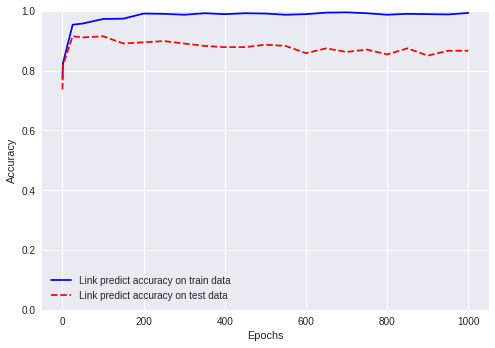

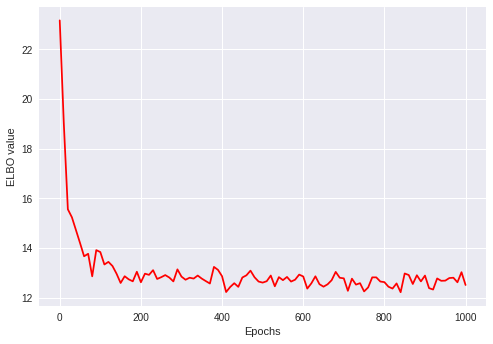

VariationalAutoencoder(
  (encoder): NeuralNetwork(
    (params): ModuleList(
      (0): Linear(in_features=15, out_features=300, bias=True)
      (1): Linear(in_features=300, out_features=5, bias=True)
    )
  )
  (decoder): NeuralNetwork(
    (params): ModuleList(
      (0): Linear(in_features=5, out_features=300, bias=True)
      (1): Linear(in_features=300, out_features=15, bias=True)
    )
  )
)

In [6]:
def train_on_synthetic_data(model, num_nodes, observed_dim, true_dim, fake_dim):
    sparsity = 0.25
    true_vectors, feature_vectors, train_adjacency_matrix, test_adjacency_matrix\
                = create_synthetic_data(num_nodes, sparsity, true_dim, observed_dim,
                                                                            fake_dim)

    # NOTE that there exists the 'interchangeability problem'
    # XR^TRX = X^TX
    # Y = XR^T
    
    # Initialize optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    train_losses = []
    test_losses = []
    obj_losses = []
    epochs = []
    all_epochs = []

    for epoch in range(1001): 
        # Do round-robin optimization
        for idx in range(num_nodes):
            x_ND = Variable(torch.FloatTensor([feature_vectors[idx, :]]))
            ys_ND = list()
            observed_entries = train_adjacency_matrix[idx]
            other_vec_idx = [entry[0][1] for entry in observed_entries]
            vals = [entry[1] for entry in observed_entries]

            for idy in other_vec_idx:
                ys_ND.append(feature_vectors[idy, :])

            ys_ND = Variable(torch.FloatTensor(ys_ND))
            optimizer.zero_grad()

            # NOTE:
            # expected_ll refers to the expected log likelihood term of ELBO
            # kl refers to the KL divergence term of the ELBO
            # matrix_loss refers to the matrix reconstruction loss
            neg_expected_ll, KL, matrix_loss, _ = model.calc_vi_loss(x_ND, ys_ND, vals, n_mc_samples=10)
            
            KL = 1/len(observed_entries) * KL
            # TODO: scale the KL term
            # ELBO loss = negative expected log likelihood + KL
            elbo_loss = neg_expected_ll + KL
            
            elbo_loss.backward()
            optimizer.step()
            
        if epoch % 10 == 0:
            all_epochs.append(epoch)
            ELBOs.append(-elbo_loss)
            

        if epoch in [0, 1, 25] or epoch % 50 == 0:
            all_vectors = Variable(torch.FloatTensor(feature_vectors))
            train_accuracy = classification_accuracy(model, all_vectors, train_adjacency_matrix)
            test_accuracy = classification_accuracy(model, all_vectors, test_adjacency_matrix)
            epochs.append(epoch)
            train_losses.append(train_accuracy)
            test_losses.append(test_accuracy)
            
            print("epoch: ", epoch, " - objective loss: ", np.around(elbo_loss.data.item(),4), " - train accuracy: ",
                  np.around(train_accuracy,4), " - test accuracy: ", np.around(test_accuracy, 4))


    plt.plot(epochs, train_losses, '-', color='b', label='Link predict accuracy on train data')
    plt.plot(epochs, test_losses, '--', color='r', label='Link predict accuracy on test data')
    plt.ylim((0, 1))
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    
    plt.plot(all_epochs, ELBOs, '-', color='r', label='ELBO')
    plt.ylabel('ELBO value')
    plt.xlabel('Epochs')
    plt.show()

    return model

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

num_nodes = 100
observed_dim = 10
true_dim = 3
num_fake_dim = 5

hidden_layer_sizes = [300]
naive_model = VariationalAutoencoder(n_dims_code=5, \
                               n_dims_data=observed_dim+num_fake_dim, \
                               hidden_layer_sizes=hidden_layer_sizes)

train_on_synthetic_data(naive_model, num_nodes, observed_dim, true_dim, num_fake_dim)

# inference_engine = FactorizedHierarchicalInvGamma
# hsbnn_model = VariationalAutoencoderHSP(inference_engine,
#                                n_dims_code=5, \
#                                n_dims_data=observed_dim+num_fake_dim, \
#                                hidden_layer_sizes=hidden_layer_sizes)
# train_on_synthetic_data(hsbnn_model, num_nodes, observed_dim, true_dim, num_fake_dim)
